This example showcases fitting and assessing Generalized Linear Models using the GENMOD action.                                 
The steps include:                                                   
                                                                      
1. PREPARE                                                          
  a) Check data is loaded into CAS  
<br>                                                                      
2. Perform Modeling on the Binary Target  
  a) Assuming binary distribution, using logit link  
  b) Plot ROC curve                                                 

### Import packages

In [1]:
from swat import *
import pandas as pd
import matplotlib.pyplot as plt
from swat.render import render_html
%matplotlib inline

### CAS Server connection details

In [2]:
cashost='sasserver.demo.sas.com'
casport=5570
casauth='~/.authinfo'

### Start CAS session

In [3]:
sess = CAS(cashost, casport, authinfo=casauth, caslib="casuser")

### Import action sets

In [4]:
sess.loadactionset(actionset="sampling")
sess.loadactionset(actionset="regression")
sess.loadactionset(actionset="percentile")

NOTE: Added action set 'sampling'.
NOTE: Added action set 'regression'.
NOTE: Added action set 'percentile'.


[actionset]

 'percentile'

+ Elapsed: 0.000174s, sys: 0.001s, mem: 0.0287mb

### Set variables for input data

In [5]:
indata_dir         = "data"
indata             = "hmeq"
im_class_inputs    = "reason, job"
im_interval_inputs = "im_clage, clno, im_debtinc, loan, mortdue, value, im_yoj, im_ninq, derog, im_delinq"; 
target             = "bad"

### Load data into CAS if needed

In [6]:
if not sess.table.tableExists(table=indata).exists:
    sess.loadTable(caslib="casuser", path=indata_dir+"/"+indata+".sas7bdat", casout={"name":indata})

NOTE: Cloud Analytic Services made the file data/hmeq.sas7bdat available as table HMEQ in caslib CASUSER(viyauser).


### Impute missing values

In [7]:
# Pipelined imputation using transform action
sess.dataPreprocess.transform(
  table={"name":indata},
  casOut={"name":"hmeq_prepped", "replace":True},
  copyAllVars=True,
  outVarsNameGlobalPrefix="IM",
  requestPackages=[
    {"impute":{"method":"MEAN"}, "inputs":{"clage"}},
    {"impute":{"method":"MEDIAN"}, "inputs":{"delinq"}},
    {"impute":{"method":"RANDOM"}, "inputs":{"ninq"}},
    {"impute":{"method":"VALUE", "valuesContinuous":{50, 100}}, "inputs":{"debtinc", "yoj"}}
  ]
)

[TransInfo]

 Transformation Requests for HMEQ
 
   ActualName  NTransVars ImputeMethod          Seed
 0       _TR1           1         Mean           NaN
 1       _TR2           1       Median           NaN
 2       _TR3           1       Random  1.801404e+09
 3       _TR4           2        Value           NaN

[VarTransInfo]

 Variable Transformation Information for HMEQ
 
   Variable Transformation   ResultVar     N  NMiss  ImputedValueContinuous
 0    CLAGE             IM    IM_CLAGE  5652    308              179.766275
 1  DEBTINC             IM  IM_DEBTINC  4693   1267              100.000000
 2   DELINQ             IM   IM_DELINQ  5380    580                0.000000
 3     NINQ             IM     IM_NINQ  5450    510                     NaN
 4      YOJ             IM      IM_YOJ  5445    515               50.000000

[OutputCasTables]

               casLib          Name  Rows  Columns  \
 0  CASUSER(viyauser)  hmeq_prepped  5960       18   
 
                                             casTable  
 0  CASTable('hmeq_prepped', caslib='CASUSER(viyau...  

+ Elapsed: 0.0205s, user: 0.018s, sys: 0.005s, mem: 9.53mb

### Partition the data into training and validation 

In [8]:
sess.sampling.stratified(
  table={"name":"hmeq_prepped", "groupBy":target},
  output={"casOut":{"name":"hmeq_part", "replace":True}, "copyVars":"ALL"},
  samppct=70,
  partind=True
)

NOTE: Using SEED=706547095 for sampling.


[outputSize]

 {'outputNObs': 5960.0, 'outputNVars': 19}

[STRAFreq]

 Frequencies
 
    ByGrpID           BAD  NObs  NSamp
 0        0             0  4771   3340
 1        1             1  1189    832

[OutputCasTables]

               casLib       Name Label  Rows  Columns  \
 0  CASUSER(viyauser)  hmeq_part        5960       19   
 
                                             casTable  
 0  CASTable('hmeq_part', caslib='CASUSER(viyauser)')  

+ Elapsed: 0.0166s, user: 0.01s, sys: 0.007s, mem: 9.74mb

### The binary target model using LOGIT link 

In [9]:
# Assuming binary distribution, using logit link, fit a GLM using the Genselect procedure
gm = sess.regression.genmod(
  table={"name":"hmeq_part"},
  classVars=[{"vars":{"reason", "job"}}],
  model={
    "depvars":[{"name":target, "options":{"event":"1"}}],
    "effects":[{"vars":{"reason", "job", "im_clage", "clno", 
                                  "im_debtinc", "loan", "mortdue", "value",
                                  "im_yoj", "im_ninq", "derog", "im_delinq"}}],
    "dist":"BINARY",
    "link":"LOGIT"
  },
  selection={"method":"FORWARD", "choose":"VALIDATE", "select":"SBC", "stop":"SBC"},
  partByVar={"name":"_partind_", "train":"1", "validate":"0"},
  output={
    "casOut":{"name":"_scored_glm", "replace":True}, 
    "copyVars":"ALL",
    "pred":"p_bad1"
  }
)

# Output model statistics
render_html(gm)

# Compute p_bad0 variable (1-pbad1)
sess.dataStep.runCode(
  code="data _scored_glm; set _scored_glm; p_bad0=1-p_bad1; run;"
)


NOTE: Convergence criterion (GCONV=1E-8) satisfied.


Model Information 
 RowId 
 Description 
 Value 
 
 
 DATA Data Source HMEQ_PART 
 RESPONSEVAR Response Variable BAD 
 DIST Distribution Binary 
 LINK Link Function Logit 
 TECH Optimization Technique Newton-Raphson with Ridging 
 
 
 
 
 Number of Observations 
 RowId 
 Description 
 Total 
 Training 
 Validation 
 
 
 NREAD Number of Observations Read 5960 4172 1788 
 NUSED Number of Observations Used 4609 3232 1377 
 
 
 
 
 Response Profile 
 Ordered Value 
 BAD 
 BAD 
 Total Frequency 
 Training 
 Validation 
 Probability Modeled 
 
 
 1 0 0 3693 2578 1115 
 2 1 1 916 654 262 * 
 
 
 
 
 Class Level Information 
 Class 
 Levels 
 Values 
 
 
 REASON 2 DebtCon HomeImp 
 JOB 6 Mgr Office Other ProfExe Sales Self 
 
 
 
 
 Selection Information 
 Description 
 Value 
 Numeric Value 
 
 
 Selection Method Forward nan 
 Select Criterion SBC nan 
 Choose Criterion Validation ASE nan 
 Stop Criterion SBC nan 
 Effect Hierarchy Enforced None nan 
 Stop Horizon 3 3 
 
 
 
 
 Convergence Status 
 Reason 
 Status 
 Max Gradient 
 
 
 Convergence criterion (GCONV=1E-8) satisfied. 0 8.2887522E-9 
 
 
 
 
 Selection Summary 
 Control 
 Step 
 Effect Entered 
 Number Of Effects 
 SBC 
 Optimal SBC 
 Validation ASE 
 Optimal ValidationASE 
 
 
 0 Intercept 1 3263.6424272 0 0.1542125156 0 
 - 1 IM_DEBTINC 2 2319.7281033 0 0.105074988 0 
 2 IM_DELINQ 3 2262.1479268 0 0.0989813694 0 
 3 IM_CLAGE 4 2165.1205216 0 0.0952765891 0 
 4 DEROG 5 2096.2412249 0 0.0903739398 0 
 5 IM_NINQ 6 2083.6475786 0 0.0905025379 0 
 6 IM_YOJ 7 2081.7986929 0 0.0908619866 0 
 7 CLNO 8 2079.1560373 0 0.0909543778 0 
 8 JOB 9 2078.9755633 1 0.0902994338 1 
 9 REASON 10 2085.2079052 0 0.0909489784 0 
 10 VALUE 11 2092.6727614 0 0.0910586201 0 
 11 LOAN 12 2100.7031904 0 0.0910161284 0 
 
 
 
 
 Stop Reason 
 Reason 
 Code 
 
 
 Selection stopped at a local minimum of the SBC criterion. 6 
 
 
 
 
 Selection Reason 
 Reason 
 
 
 The model at step 8 is selected where Validation ASE is 0.090299. 
 
 
 
 
 Selected Effects 
 Label 
 Effects 
 
 
 Selected Effects: Intercept IM_DELINQ IM_CLAGE DEROG IM_YOJ CLNO IM_DEBTINC JOB IM_NINQ 
 
 
 
 
 Dimensions 
 RowId 
 Description 
 Value 
 
 
 NDESIGNCOLS Columns in Design 14 
 NEFFECTS Number of Effects 9 
 MAXEFCOLS Max Effect Columns 6 
 DESIGNRANK Rank of Design 13 
 OPTPARM Parameters in Optimization 13 
 
 
 
 
 Fit Statistics 
 RowId 
 Description 
 Training 
 Validation 
 
 
 M2LL -2 Log Likelihood 1976.3441806 843.27844847 
 AIC AIC (smaller is better) 2002.3441806 869.27844847 
 AICC AICC (smaller is better) 2002.4572944 869.54550643 
 SBC SBC (smaller is better) 2081.3953141 937.23806096 
 ASE Average Square Error 0.0914359463 0.0902994338 
 
 
 
 
 Parameter Estimates 
 Effect 
 JOB 
 Parameter 
 Parameter 
 DF 
 Estimate 
 Standard Error 
 Chi-Square 
 Pr > ChiSq 
 
 
 Intercept Intercept Intercept 1 -2.696945645 0.3667450971 54.077393938 1.927461E-13 
 IM_DELINQ IM_DELINQ IM_DELINQ 1 0.7762212377 0.0640141589 147.03440034 7.712784E-34 
 IM_CLAGE IM_CLAGE IM_CLAGE 1 -0.005428893 0.0008619395 39.670628005 3.006127E-10 
 DEROG DEROG DEROG 1 0.5122282658 0.0783986309 42.688424175 6.419104E-11 
 IM_YOJ IM_YOJ IM_YOJ 1 -0.021905174 0.0056695188 14.927979661 0.0001116941 
 CLNO CLNO CLNO 1 -0.019724952 0.0062962221 9.814582267 0.001731336 
 IM_DEBTINC IM_DEBTINC IM_DEBTINC 1 0.0416509803 0.0018343925 515.5442449 3.94419E-114 
 JOB Mgr JOB Mgr JOB_Mgr 1 0.0140445314 0.3372063893 0.0017346942 0.9667779848 
 JOB Office JOB Office JOB_Office 1 -0.768324372 0.3481214775 4.8711060342 0.0273099914 
 JOB Other JOB Other JOB_Other 1 -0.098486 0.3146454156 0.0979729494 0.754275869 
 JOB ProfExe JOB ProfExe JOB_ProfExe 1 -0.409675283 0.3325303586 1.5178082975 0.2179514647 
 JOB Sales JOB Sales JOB_Sales 1 1.3553482678 0.455565408 8.8511628334 0.0029290223 
 JOB Self JOB Self JOB_Self 0 0 nan nan nan 
 IM_NINQ IM_NINQ IM_NINQ 1 0.1128498376 0.0269300698 17.560097295 0.0000278369 
 
 
 
 
 Task Timing 
 RowId 
 Task 
 Time 
 Re

NOTE: Missing values were generated as a result of performing an operation on missing values.
      Each place is given by: (Number of times) at (Line):(Column).
      843 at 0:43


,casLib,Name,Rows,Columns,casTable
0,CASUSER(viyauser),_scored_glm,5960,20,"CASTable('_scored_glm', caslib='CASUSER(viyaus..."
,casLib,Name,Rows,Columns,casTable
0,CASUSER(viyauser),_scored_glm,5960,21,"CASTable('_scored_glm', caslib='CASUSER(viyaus..."


### Assess model performance (GLM)  

In [10]:
glmAssess=sess.percentile.assess(
  table={
    "name":"_scored_glm", 
    "where": "strip(put(_partind_, best.))='0'"
  },
  inputs=[{"name":"p_bad1"}],
  response="bad",
  event="1",
  pVar={"p_bad0"},
  pEvent={"0"}
)

glm_fitstat =glmAssess.FitStat
glm_rocinfo =glmAssess.ROCInfo
glm_liftinfo=glmAssess.LIFTInfo

### Create ROC and Lift plots using validation data 

--------------------------AUC (using validation data)---------------------------


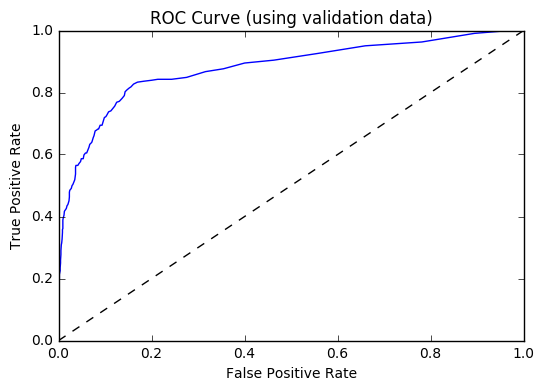

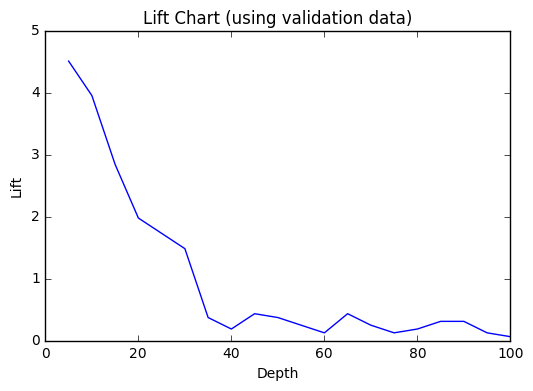

In [11]:
# Print AUC (Area Under the ROC Curve) 
print("AUC (using validation data)".center(80, '-'))
glm_rocinfo[["C"]].drop_duplicates(keep="first")

#/* Draw ROC charts */ 
plt.figure()
plt.plot(glm_rocinfo["FPR"], glm_rocinfo["Sensitivity"])
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (using validation data)")
plt.show()

#/* Draw lift charts */
plt.figure()
plt.plot(glm_liftinfo["Depth"], glm_liftinfo["Lift"])
plt.xlabel("Depth")
plt.ylabel("Lift")
plt.title("Lift Chart (using validation data)")
plt.show()


### End CAS session

In [12]:
sess.close()